# Conjugate gradient method

This notebook presents the Conjugate gradient methods for iteratively solving linear systems.

### References

* Aster, R. C., Borchers, B., and Thurber, C. H. Parameter Estimation and Inverse Problems, 3rd edition Elsevier Academic Press, 2019, ISBN: 978-0-12-804651-7

* Shewchuk, J. R. (1994). An introduction to the Conjugate Gradient Method without the agonizing
 pain, 1 1/4 ed.: School of Computer Science Carnegie Mellon, University Pittsburgh, [versão pdf](https://www.cs.cmu.edu/~quake-papers/painless-conjugate-gradient.pdf)

* Kelley, C. T. Iterative methods for optimization, SIAM, 1999, [versão pdf](http://www.siam.org/books/kelley/fr18/)

* Golub, G. H. and C. F. Van Loan, (2013), Matrix computations, 4th edition, Johns Hopkins University Press, ISBN 978-1-4214-0794-4.

In [1]:
import numpy as np
from scipy.signal import ricker
from scipy.linalg import toeplitz
import matplotlib.pyplot as plt

### Conjugate gradient method for symmetric positive-definite systems

The *conjugate gradient method* solves the linear system

<a id='eq1'></a>
$$
\mathbf{A} \, \mathbf{x} = \mathbf{b} \quad , \tag{1}
$$

where $\mathbf{A}$ is an $N \times N$ symmetric and positive definite matrix, by generating a sequence of approximate solutions $\mathbf{x}_{k}$ that converges to

<a id='eq2'></a>
$$
\tilde{\mathbf{x}} = \mathbf{A}^{-1} \mathbf{b} \quad . \tag{2}
$$

The solution $\tilde{\mathbf{x}}$ is represented by:

<a id='eq3'></a>
$$
\tilde{\mathbf{x}} = \sum\limits_{k = 0}^{N-1} \alpha_{k} \mathbf{p}_{k} \quad , \tag{3}
$$

where vectors $\mathbf{p}_{k}$, $k = 0, \dots, N-1$, satisfy the condition

<a id='eq4'></a>
$$
\mathbf{p}_{i}^{\top}\mathbf{A}\mathbf{p}_{j} = 0 \quad , \quad  \text{for any} \:\: i \ne j \quad , \tag{4}
$$

and $\alpha_{k}$ are constants that we will define later. The approximating solution $\mathbf{x}_{k+1}$ depends on the previous solution $\mathbf{x}_{k}$ according to:

<a id='eq5'></a>
$$
\mathbf{x}_{k+1} = \mathbf{x}_{k} + \alpha_{k} \mathbf{p}_{k} \quad . \tag{5}
$$

The vector $\mathbf{p}_{k+1}$ depends on vector $\mathbf{p}_{k}$ according to:

<a id='eq6'></a>
$$
\mathbf{p}_{k+1} = \mathbf{r}_{k+1} + \beta_{k} \mathbf{p}_{k} \quad , \tag{6}
$$

where $\beta_{k}$, $k = 0, \dots, N-1$, are constants defined later and $\mathbf{r}_{k+1}$ is the residuals vector

<a id='eq7'></a>
$$
\begin{split}
\mathbf{r}_{k+1} 
&= \mathbf{b} - \mathbf{A} \, \mathbf{x}_{k+1} \\
&= \mathbf{b} - \mathbf{A} \left( \mathbf{x}_{k} + \alpha_{k}\mathbf{p}_{k} \right) \\
&= \left( \mathbf{b} - \mathbf{A} \, \mathbf{x}_{k} \right) - \alpha_{k} \mathbf{A} \, \mathbf{p}_{k} \\
&= \mathbf{r}_{k} - \alpha_{k} \mathbf{A} \, \mathbf{p}_{k}
\end{split} \quad , \tag{7}
$$

and $\mathbf{r}_{k} = \mathbf{b} - \mathbf{A} \, \mathbf{x}_{k}$ is the residuals vector produced by the approximating solution $\mathbf{x}_{k}$. The constants $\alpha_{k}$ (equations [3](#eq3), [5](#eq5), [7](#eq7)) and $\beta_{k}$ ([equation 6](#eq6)) are defined so that the following conditions are satisfied:

1. $\mathbf{r}_{k+1}^\top \mathbf{r}_{i} = 0 \quad$ ;
2. $\mathbf{r}_{k+1}^\top \mathbf{r}_{k} = 0 \quad$ ;
3. $\mathbf{r}_{k+1}^\top \mathbf{p}_{i} = 0 \quad$ ;
4. $\mathbf{p}_{k+1}^\top \mathbf{A} \mathbf{p}_{i} = 0 \quad$ ([equation 4](#eq4)) ;
5. $\mathbf{p}_{k+1}^\top \mathbf{A} \mathbf{p}_{k} = 0 \quad$ ([equation 4](#eq4)) ;

where $i = 0, \dots, k$. It can be shown that the constants $\alpha_{k}$ and $\beta_{k}$ satisfying the conditions above are given by (Aster et al., 2019, p. 160-164):

<a id='eq8'></a>
$$
\alpha_{k} = \frac{\mathbf{r}_{k}^{\top}\mathbf{r}_{k}}{\mathbf{p}_{k}^{\top}\mathbf{A}\mathbf{p}_{k}} \tag{8}
$$

and

<a id='eq9'></a>
$$
\beta_{k} = \frac{\mathbf{r}_{k}^{\top}\mathbf{r}_{k}}{\mathbf{r}_{k+1}^{\top}\mathbf{r}_{k+1}} \quad . \tag{9}
$$

The cell below contains an implementation of the *conjugate gradient method* (Golub and Van Loan, 2013, modified Algorithm 11.3.3, p. 635).

In [2]:
def cg_method(A, dobs, p0, tol):
    '''
    Solve a positive-definite linear system by using the 
    conjugate gradient method (Golub and Van Loan, 2013,
    modified Algorithm 11.3.3, p. 635).
    
    Parameters:
    -----------
    A : array 2D
        Symmetric positive definite N x N matrix.
    dobs : array 1D
        Observed data vector with N elements.
    p0 : array 1D
        Initial approximation of the solution p.
    tol : float
        Positive scalar controlling the termination criterion.
    
    Returns:
    --------
    p : array 1D
        Solution of the linear system.
    dpred : array 1D
        Predicted data vector produced by p.
    residuals_L2_norm_values : list
        L2 norm of the residuals along the iterations.
    '''

    A = np.asarray(A)
    dobs = np.asarray(dobs)
    p0 = np.asarray(p0)
    assert A.shape[0] == A.shape[1], 'A must be square'
    assert dobs.size == A.shape[0] == p0.size, 'A order, dobs size and p0 size must be the same'
    assert np.isscalar(tol) & (tol > 0.), 'tol must be a positive scalar'

    N = dobs.size
    p = p0.copy()
    # residuals vector
    res = dobs - np.dot(A, p)
    # residuals L2 norm
    res_L2 = np.dot(res,res)
    # Euclidean norm of the residuals
    res_norm = np.sqrt(res_L2)
    # List of Euclidean norm of the residuals
    residuals_norm_values = [res_norm]
    # positive scalar controlling convergence
    delta = tol*np.linalg.norm(dobs)

    # iteration 1
    if res_norm > delta:
        q = res
        w = np.dot(A, q)
        mu = res_L2/np.dot(q,w)
        p += mu*q
        res -= mu*w
        res_L2_ = res_L2
        res_L2 = np.dot(res,res)
        res_norm = np.sqrt(res_L2)
    
    residuals_norm_values.append(res_norm)
    
    # remaining iterations
    while res_norm > delta:
        tau = res_L2/res_L2_
        q = res + tau*q
        w = np.dot(A, q)
        mu = res_L2/np.dot(q,w)
        p += mu*q
        res -= mu*w
        res_L2_ = res_L2
        res_L2 = np.dot(res,res)
        res_norm = np.sqrt(res_L2)
        residuals_norm_values.append(res_norm)
    
    dpred = np.dot(A,p)

    return p, dpred, residuals_norm_values

### Application to synthetic data

In [3]:
N = 500

In [4]:
np.random.seed(10)

In [5]:
G = np.random.rand(N,N) + 3*np.identity(N)
A = np.dot(G, G.T)

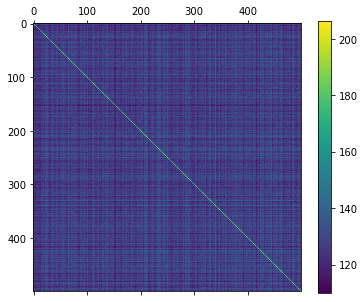

In [6]:
plt.figure(figsize=(6,5))
plt.matshow(A=A, fignum=0)
plt.colorbar()
plt.show()

In [7]:
# generate a parameter vector
pulses = np.zeros(N)
N_pulses = 20
indices_pulses = np.random.randint(low=0, high=N+1, size=N_pulses)
values_pulses = 10*np.random.rand(N_pulses)
pulses[indices_pulses] = values_pulses
wavelet = ricker(points=N, a=10)
p_true = np.convolve(a=wavelet, v=pulses, mode='same')

In [8]:
# set the initial approximation
p_initial = np.zeros(N)

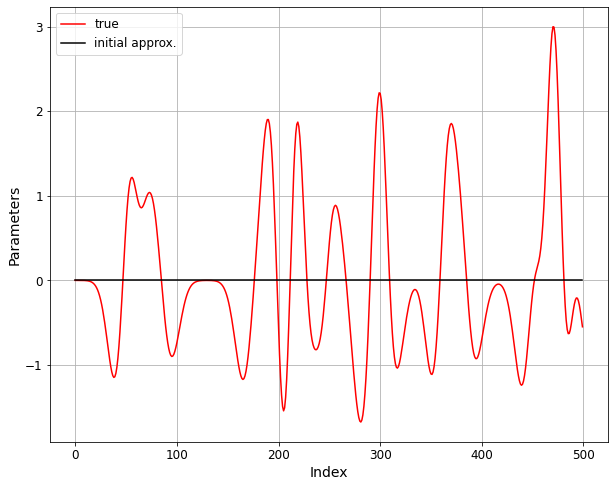

In [9]:
plt.figure(figsize=(10,8))
plt.plot(p_true, 'r-', label = 'true')
plt.plot(p_initial, 'k-', label = 'initial approx.')
plt.ylabel('Parameters', fontsize=14)
plt.xlabel('Index', fontsize=14)
plt.yticks(fontsize=12)
plt.xticks(fontsize=12)
plt.legend(loc='best', fontsize=12)
plt.grid()
plt.show()

In [10]:
# compute the observed data vector
dobs = np.dot(A, p_true)

In [11]:
tolerance = 1e-3

In [12]:
p_estimated, dpred, phi_values = cg_method(A=A, dobs=dobs, 
                                           p0=p_initial, tol=tolerance)

In [13]:
num_iterations = np.arange(1, len(phi_values)+1)

In [14]:
d_initial = np.dot(A, p_initial)

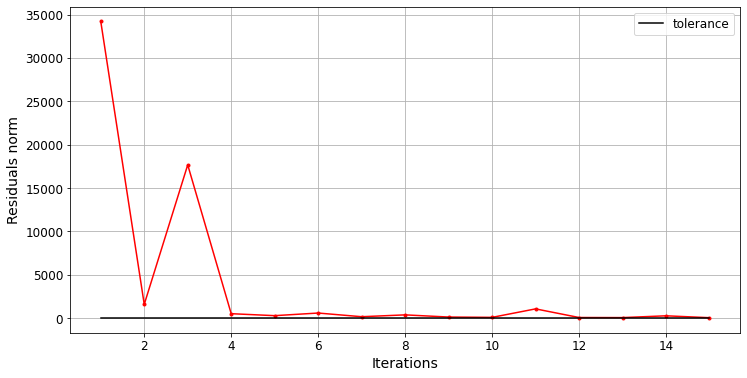

In [15]:
plt.figure(figsize=(12,6))
plt.plot(num_iterations, phi_values, 'r.-')
plt.plot([np.min(num_iterations), np.max(num_iterations)],
         [tolerance, tolerance], 'k-', label = 'tolerance')
plt.ylabel('Residuals norm', fontsize=14)
plt.xlabel('Iterations', fontsize=14)
plt.yticks(fontsize=12)
plt.xticks(fontsize=12)
plt.legend(loc='best', fontsize=12)
plt.grid()
plt.show()

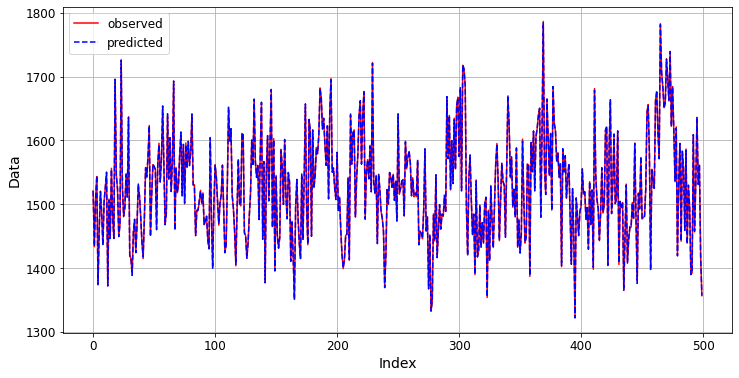

In [16]:
plt.figure(figsize=(12,6))
plt.plot(dobs, 'r-', label = 'observed')
#plt.plot(d_initial, 'k-', label = 'initial approx.')
plt.plot(dpred, 'b--', label = 'predicted')
plt.ylabel('Data', fontsize=14)
plt.xlabel('Index', fontsize=14)
plt.yticks(fontsize=12)
plt.xticks(fontsize=12)
plt.legend(loc='best', fontsize=12)
plt.grid()
plt.show()

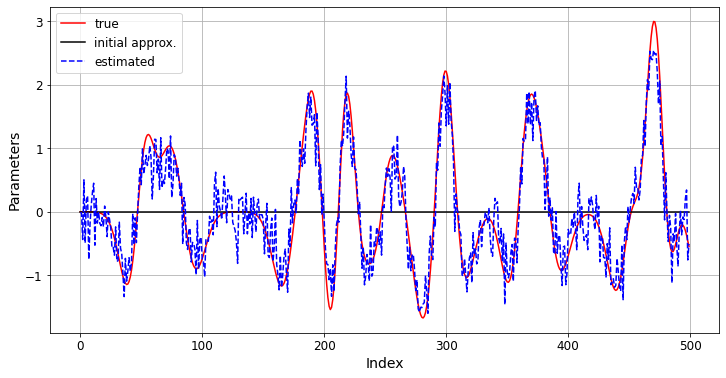

In [17]:
plt.figure(figsize=(12,6))
plt.plot(p_true, 'r-', label = 'true')
plt.plot(p_initial, 'k-', label = 'initial approx.')
plt.plot(p_estimated, 'b--', label = 'estimated')
plt.ylabel('Parameters', fontsize=14)
plt.xlabel('Index', fontsize=14)
plt.yticks(fontsize=12)
plt.xticks(fontsize=12)
plt.legend(loc='best', fontsize=12)
plt.grid()
plt.show()

### Conjugate gradient normal equation residual method for normal equations

The *conjugate gradient method* method by itself can only be applied to positive definite systems of equations, and is thus not directly applicable to general least squares problems (Aster et al., 2019, p. 165). However, simple modifications in the previous algorithm can be made in order to solve a least squares problem. This modified version are called *conjugate gradient least squares* (CGLS) method (Aster et al., 2019, 165) or *conjugate gradient normal equation residual* (CGNR) method (Golub and Van Loan, 2013, modified Algorithm 11.3.3 according to Figure 11.3.1, p. 637).

In [18]:
def cgnr_method(A, dobs, p0, tol):
    '''
    Solve a linear system by using the conjugate gradient 
    normal equation residual method (Golub and Van Loan, 2013,
    modified Algorithm 11.3.3 according to Figure 11.3.1 ,
    p. 637).
    
    Parameters:
    -----------
    A : array 2D
        Rectangular N x M matrix.
    dobs : array 1D
        Observed data vector with N elements.
    p0 : array 1D
        Initial approximation of the M x 1 solution p.
    tol : float
        Positive scalar controlling the termination criterion.
    
    Returns:
    --------
    p : array 1D
        Solution of the linear system.
    dpred : array 1D
        Predicted data vector produced by p.
    residuals_L2_norm_values : list
        L2 norm of the residuals along the iterations.
    '''

    A = np.asarray(A)
    dobs = np.asarray(dobs)
    p0 = np.asarray(p0)
    assert dobs.size == A.shape[0], 'A order and dobs size must be the same'
    assert p0.size == A.shape[1], 'A order and p0 size must be the same'
    assert np.isscalar(tol) & (tol > 0.), 'tol must be a positive scalar'

    N = dobs.size
    p = p0.copy()
    # residuals vector
    res = dobs - np.dot(A, p)

    # auxiliary variable
    z = np.dot(A.T, res)

    # L2 norm of z
    z_L2 = np.dot(z,z)
    # Euclidean norm of the residuals
    res_norm = np.linalg.norm(res)
    # List of Euclidean norm of the residuals
    residuals_norm_values = [res_norm]
    # positive scalar controlling convergence
    delta = tol*np.linalg.norm(dobs)

    # iteration 1
    if res_norm > delta:
        q = z
        w = np.dot(A, q)
        mu = z_L2/np.dot(w,w)
        p += mu*q
        res -= mu*w
        z = np.dot(A.T, res)
        z_L2_ = z_L2
        z_L2 = np.dot(z,z)
        res_norm = np.linalg.norm(res)
    
    residuals_norm_values.append(res_norm)
    
    # remaining iterations
    while res_norm > delta:
        tau = z_L2/z_L2_
        q = z + tau*q
        w = np.dot(A, q)
        mu = z_L2/np.dot(w,w)
        p += mu*q
        res -= mu*w
        z = np.dot(A.T, res)
        z_L2_ = z_L2
        z_L2 = np.dot(z,z)
        res_norm = np.linalg.norm(res)
        residuals_norm_values.append(res_norm)
    
    dpred = np.dot(A,p)

    return p, dpred, residuals_norm_values

### Application to synthetic data

In [19]:
N = 600
M = 450

In [20]:
np.random.seed(38)

In [21]:
A = np.random.rand(N,M)

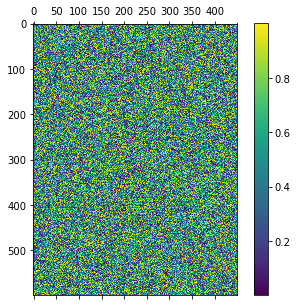

In [22]:
plt.figure(figsize=(6,5))
plt.matshow(A=A, fignum=0)
plt.colorbar()
plt.show()

In [23]:
# generate a parameter vector
pulses = np.zeros(M)
M_pulses = 18
indices_pulses = np.random.randint(low=0, high=M+1, size=M_pulses)
values_pulses = 10*np.random.rand(M_pulses)
pulses[indices_pulses] = values_pulses
wavelet = ricker(points=M, a=10)
p_true = np.convolve(a=wavelet, v=pulses, mode='same')

In [24]:
# set the initial approximation
p_initial = np.zeros(M)

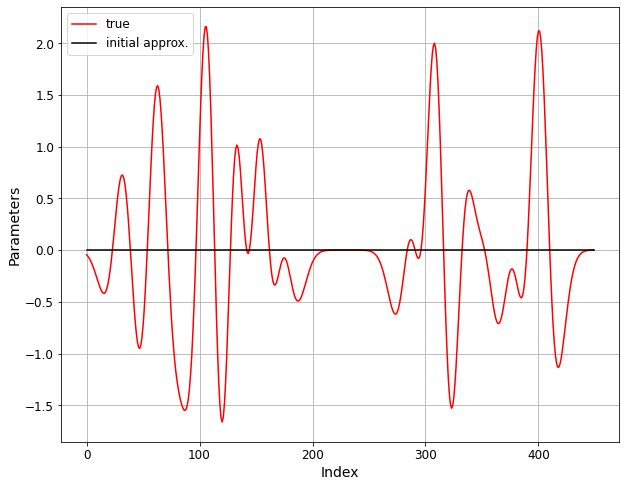

In [25]:
plt.figure(figsize=(10,8))
plt.plot(p_true, 'r-', label = 'true')
plt.plot(p_initial, 'k-', label = 'initial approx.')
plt.ylabel('Parameters', fontsize=14)
plt.xlabel('Index', fontsize=14)
plt.yticks(fontsize=12)
plt.xticks(fontsize=12)
plt.legend(loc='best', fontsize=12)
plt.grid()
plt.show()

In [26]:
# compute the observed data vector
dobs = np.dot(A, p_true)

In [27]:
tolerance = 1e-3

In [28]:
p_estimated, dpred, phi_values = cgnr_method(A=A, dobs=dobs, 
                                             p0=p_initial, tol=tolerance)

In [29]:
num_iterations = np.arange(1, len(phi_values)+1)

In [30]:
d_initial = np.dot(A, p_initial)

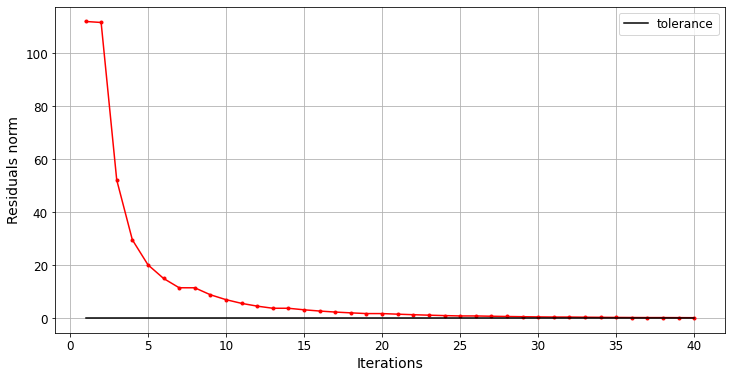

In [31]:
plt.figure(figsize=(12,6))
plt.plot(num_iterations, phi_values, 'r.-')
plt.plot([np.min(num_iterations), np.max(num_iterations)],
         [tolerance, tolerance], 'k-', label = 'tolerance')
plt.ylabel('Residuals norm', fontsize=14)
plt.xlabel('Iterations', fontsize=14)
plt.yticks(fontsize=12)
plt.xticks(fontsize=12)
plt.legend(loc='best', fontsize=12)
plt.grid()
plt.show()

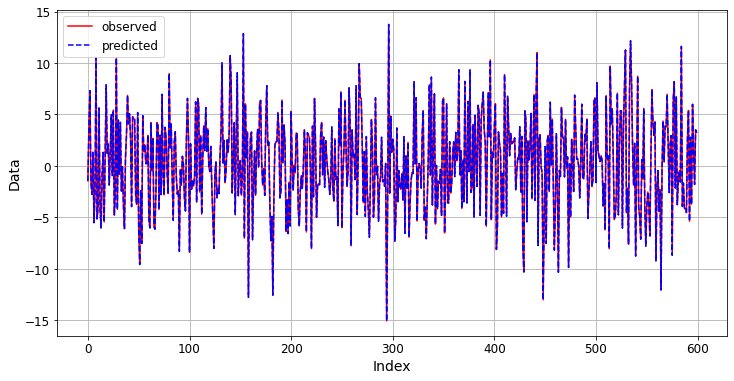

In [32]:
plt.figure(figsize=(12,6))
plt.plot(dobs, 'r-', label = 'observed')
#plt.plot(d_initial, 'k-', label = 'initial approx.')
plt.plot(dpred, 'b--', label = 'predicted')
plt.ylabel('Data', fontsize=14)
plt.xlabel('Index', fontsize=14)
plt.yticks(fontsize=12)
plt.xticks(fontsize=12)
plt.legend(loc='best', fontsize=12)
plt.grid()
plt.show()

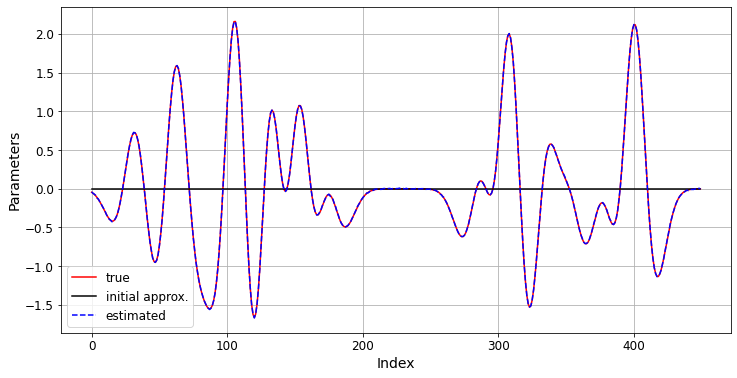

In [33]:
plt.figure(figsize=(12,6))
plt.plot(p_true, 'r-', label = 'true')
plt.plot(p_initial, 'k-', label = 'initial approx.')
plt.plot(p_estimated, 'b--', label = 'estimated')
plt.ylabel('Parameters', fontsize=14)
plt.xlabel('Index', fontsize=14)
plt.yticks(fontsize=12)
plt.xticks(fontsize=12)
plt.legend(loc='best', fontsize=12)
plt.grid()
plt.show()